IA & Data science (LU3IN0226) -- 2020-2021
--------
*&copy; Equipe pédagogique: Vincent Guigue, Christophe Marsala, Edoardo Sarti, Olivier Schwander.*

# TD-TME08: algorithme des k-moyennes

L'objectif de ce notebook est d'implémenter l'algorithme des K-moyennes.

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

*Moulouel Myriem, Loi Alessia*

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Compléter le nom de ce notebook en rajoutant les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">**[Q]**</font> **Mise à jour de la librairie `iads`**

En premier lieu, vérifier que votre librairie `iads` est bien à jour : 
- dans le fichier `Classifieurs.py`: tous les classifieurs que vous avez implémentés depuis le début des séances. Rajouter aussi dans ce fichier la fonction `leave_one_out` écrite dans le notebook précédent.
- de même, vérifier que votre fichier `utils.py` est aussi à jour.

Une fois à jour, importer la librairie pour pouvoir l'utiliser dans ce notebook.

In [52]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline  

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire frère du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Travail à réaliser
Le travail à faire se décompose en 2 phases :
- dans un premier temps, le travail porte sur la base d'apprentissage <code>base-2D.csv</code> qui contient des exemples décrits dans $R^2$. Ainsi, il est plus aisé de visualiser les résultats des fonctions à écrire ;
- dans un second temps, les fonctions écrites dans la phase précédente sont à utiliser avec la base d'apprentissage "base-Paris.csv".

**Attention**: vos fonctions doivent **dès leur création** pouvoir s'appliquer **quelle que soit la dimension** des exemples traités.


### Données d'expérimentation

Commencer par charger le fichier <code>base_2D.csv</code> qui permettra d'expérimenter vos fonctions. Dans ce qui suit, on note <code>data_2D</code> le dataframe qui contient les données de ce fichiers.


In [2]:
data_2D = pd.read_csv("data/base-2D.csv")
data_2D[0:5] 

,X,Y
0,0.0,4.0
1,1.0,3.5
2,1.0,1.0
3,2.0,1.0
4,2.0,2.0


On convertit le dataframe en array:

In [3]:
# Passer du dataframe à des arrays:
data_desc = np.array(data_2D[['X','Y']])

# obtenir les noms des colonnes :
data_noms = ['X','Y']

In [4]:
print("Minima: ",data_desc.min(axis=0), "\tMaxima:",data_desc.max(axis=0))

Minima:  [0. 1.] 	Maxima: [7. 6.]


Dans la suite de ce notebook, on appelle "base d'apprentissage" l'ensemble des exemples d'apprentissage obtenus après chargement et conversion en array.

**Rappel**: en apprentissage non-supervisé une base d'apprentissage ne contient que les descriptions des exemples, il n'y a pas de labels (classes) associés.

## Partie 1 : fonctions utiles

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>normalisation()</code>: cette fonction doit prendre en argument un <code>array A</code> et rendre l'array obtenu en normalisant <code>A</code> par la méthode vue en cours 8.

*Remarque*: avec les array numpy, il n'est pas nécessaire de faire des boucles...

In [6]:
def normalisation(data):
    minima = data.min(axis=0) # [min_x, min_y]
    maxima = data.max(axis=0) # [max_x, max_y]

    taille_i = len(data)

    desc = [[] for i in range(0,taille_i)]
    print("min",minima,"max",maxima)
    if (taille_i > 0) and (maxima.all()>minima.all()):
        taille_j = len(data[0]) # dimension de data
        for i in range(0,taille_i):
            for j in range(0,taille_j):
                x_norm = (data[i][j]-minima[j])/(maxima[j]-minima[j])
                desc[i].append(x_norm)
    desc = np.array(desc)
    return desc

min [0. 1.] max [7. 6.]


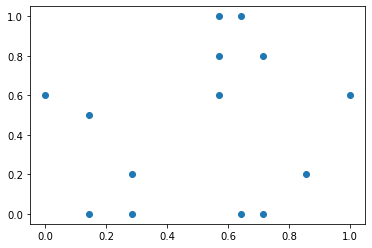

In [7]:
# Affichage des points après normalisation:

data_norm = normalisation(data_desc)

plt.scatter(data_norm[:,0],data_norm[:,1])

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>dist_vect()</code> qui calcule la distance euclidienne entre deux vecteurs représenté sous forme d'<code>array</code>.

In [10]:
def dist_vect(v1, v2):
    dist = 0
    taille_j = len(v1) # dimension
    for j in range(0,taille_j):
        dist = dist + (v1[j]-v2[j])**2
    dist = math.sqrt(dist)
    return dist

In [11]:
dist_vect(data_norm[0,:],data_norm[1,:])

0.17437936593905287

### Calcul de centroides

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>centroide()</code> qui, étant un ensemble d'exemples, contenant au moins 2 exemples donné sous la forme d'un array rend leur centroide (sous la forme d'un array).

In [12]:
def centroide(data):
    taille_i = len(data)
    taille_j = len(data[0]) # dimension
    centre = []
    for j in range(0,taille_j):
        x = np.sum(data[:,j])
        centre.append(x/taille_i)
    centre = np.array(centre)
    return centre

In [13]:
print("Ensemble d'exemples: \n",data_norm[0:2,:])

print("Centroide correspondant:\n",centroide(data_norm[0:2,:]))

Ensemble d'exemples: 
 [[0.         0.6       ]
 [0.14285714 0.5       ]]
Centroide correspondant:
 [0.07142857 0.55      ]


In [14]:
centroide(data_norm)

array([0.51020408, 0.45      ])

Dans ce qui suit, on appelle "ensemble de centroides" un array contenant $K$ vecteurs de dimensions $p$.

## Partie 2: implémentation des k-moyennes

### Inertie d'un cluster
<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>inertie_cluster</code> qui, étant donné un array contenant un ensemble d'exemples contenant au moins 2 exemples, rend la valeur de l'inertie de cet ensemble telle qu'elle a été définie dans le cours.

In [93]:
def inertie_cluster(data):
    centre = centroide(data)
    jk = 0
    for i in range(len(data)):
        dist = (dist_vect(data[i], centre))**2
        jk = jk + dist
        #print("centre: ", centre," 	Exemple:  ",data[i]," 	distance =  ",dist)
    return jk

In [94]:
np.set_printoptions(precision=3) # pour n'afficher que 3 chiffres au plus après la virgules...

print("inertie de l'ensemble :",inertie_cluster(data_norm))

np.set_printoptions(precision=8) # On remet comme c'était avant

inertie de l'ensemble : 2.975991253644316


In [95]:
print("inertie de l'ensemble :",inertie_cluster(data_norm[0:2,:]))

inertie de l'ensemble : 0.01520408163265306


<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>initialisation()</code> qui étant donné un entier $K>1$ et une base d'apprentissage de $n$ exemples rend un array contenant $K$ exemples tirés aléatoirement dans la base.
On fait l'hypothèse que $K\leq n$.

*Remarque*: étudier les fonctions de la librairie random de Python...


In [96]:
def initialisation(k, data):
    desc = []
    n = len(data)
    if n<=k:
        desc = data
    else:
        data_indice = [i for i in range(len(data))]
        indices = []
        for i in range(k):
            x = random.choice(data_indice)
            desc.append(data[x])
            data_indice.remove(x)
            indices.append(x)
    desc = np.array(desc)
    print("selectionnés ",indices)
    return desc

In [97]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

# Par exemple (mais vous ne devriez pas pouvoir retrouver exactement les mêmes !)
Centroides_test = initialisation(3,data_norm)
Centroides_test

selectionnés  [13, 2, 9]


array([[1.        , 0.6       ],
       [0.14285714, 0.        ],
       [0.64285714, 1.        ]])

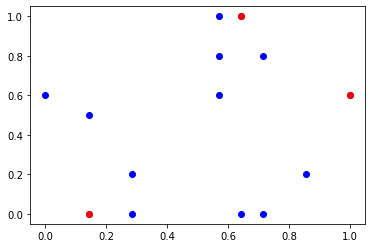

In [98]:
plt.scatter(data_norm[:,0],data_norm[:,1],color='blue')
plt.scatter(Centroides_test[:,0],Centroides_test[:,1],color='red')

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>plus_proche()</code> qui, étant donné un exemple et un array contenant un ensemble de centroides, rend l'indice du array correspondant au centroide dont l'exemple est le plus proche.
En cas d'égalité de distance, le centroide de plus petit indice est choisi.

In [99]:
def plus_proche(exemple, centroides):
    taille_j = len(centroides) # nombre de centroides
    min_dist = 1000000000
    min_centre = -1
    for i in range(taille_j):
        dist = dist_vect(exemple, centroides[i])
        if dist<min_dist:
            min_dist = dist
            min_centre = i
    return min_centre

In [100]:
for i in range(0,len(data_norm)):
    pproche = plus_proche(data_norm[i,:],Centroides_test)
    print(pproche)

1
1
1
1
1
2
2
2
1
2
1
2
0
0


### Matrice d'affectation

Etant donné une base d'apprentissage, on peut représenter une partition de cette base en K clusters à l'aide d'une matrice U contenant n lignes (une par exemple) et K colonnes (une par cluster) et telle que les contraintes suivantes sont vérifiées: 
- U[i,j] = 1 si l'exemple i appartient au cluster j
- U[i,j] = 0 si l'exemple i n'appartient pas au cluster j
- un exemple appartient à un et un seul cluster
- un cluster contient au moins un exemple

On appelle **matrice d'affectation** une telle matrice U.


<font size="+1" color="RED">**[Q]**</font> Donner une expression mathématique (pas du Python) des 2 dernières contraintes que vérifie une matrice d'affectation.

------

∀i,j∈N
i<n et i>=0 et j<K et j>=0

Uij ∈ {0, 1}

Ui = (Ui0, Ui1, Ui2 ... Uij, ... Ui(K-1))
U = (U0, U1, U2, ... U(n-1))

1) . un exemple appartient à un et un seul cluster 
∀ i,
il n'existe pas k et k' dans [0,K-1] tel que Uik=1 et Uik'=1

------

2) . un cluster contient au moins un exemple
Soit C un cluster 
C n'appartient pas à l'ensemble vide

il n'existe pas de j, tel que ∀i, Uij=0
    
------

### Implémentation en Python
Nous utilisons un dictionnaire pour représenter d'une matrice d'affectation: 
- les clés de ce dictionnaire correspondent aux $K$ indices des clusters
- les valeurs correspondent à des listes d'indices d'exemples (leur indice dans la base d'apprentissage)

Dans tout ce qui suit, une "matrice d'affectation" sera un tel dictionnaire.


<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>affecte_cluster()</code> qui, étant donné une base d'apprentissage et un ensemble de $K$ centroïdes, rend la matrice d'affectation des exemples de la base aux clusters représentés par chaque centroïde.

In [101]:
def affecte_cluster(data, centroides):
    dictionnaire = dict()
    for i in range(0,len(data)):
        pproche = plus_proche(data[i,:],centroides)
        if pproche in dictionnaire.keys():
            dictionnaire[pproche].append(i)
        else:
            dictionnaire[pproche] = [i]
    return dictionnaire

In [102]:
DictAffect = affecte_cluster(data_norm, Centroides_test)
DictAffect

{1: [0, 1, 2, 3, 4, 8, 10], 2: [5, 6, 7, 9, 11], 0: [12, 13]}

### Ensemble des centroides
Grâce à la matrice d'affectation, on peut maintenant trouver les nouveaux centroides. Ceux-ci sont déterminés en prenant les moyennes des ensembles des exemples qui sont affectés au même cluster.

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>nouveaux_centroides()</code> qui, étant donné une base d'apprentissage et une matrice d'affectation, rend l'ensemble des nouveaux centroides obtenus.

In [103]:
def nouveaux_centroides(data, dictAffect):
    nb_centre = dictAffect.keys()
    centres = []
    for i in nb_centre:
        centre = centroide(data[DictAffect[i]])
        centres.append(centre)
    centres = np.array(centres)
    return centres

In [104]:
data_norm[DictAffect[0]]

array([[0.85714286, 0.2       ],
       [1.        , 0.6       ]])

In [105]:
centroide(data_norm[DictAffect[0]])

array([0.92857143, 0.4       ])

In [106]:
nouveaux_centroides(data_norm, DictAffect)

array([[0.31632653, 0.18571429],
       [0.61428571, 0.84      ],
       [0.92857143, 0.4       ]])

### Inertie globale d'une partition

<font size="+1" color="RED">**[Q]**</font> En utilisant la fonction `inertie_cluster()`, écrire la fonction `inertie_globale()` qui, étant donné une base d'apprentissage et une matrice d'affectation, rend la valeur de l'inertie globale du partitionnement correspondant.


In [107]:
def inertie_globale(data, dictAffect):
    nb_cluster = dictAffect.keys()
    global_inert = 0
    for i in nb_cluster:
        global_inert = global_inert + inertie_cluster(data[DictAffect[i]])

        #print(global_inert)
    return global_inert

In [108]:
np.set_printoptions(precision=3) # pour n'afficher que 3 chiffres au plus après la virgules...

print("Inertie globale: ",inertie_globale(data_norm,DictAffect))

np.set_printoptions(precision=8) # pour n'afficher que 3 chiffres au plus après la virgules...


Inertie globale:  1.0542157434402333


### Algorithme des K-moyennes

<font size="+1" color="RED">**[Q]**</font> En utilisant les fonctions précédentes, implémenter l'algorithme des K-moyennes.
Pour cela, écrire une fonction <code>kmoyennes()</code> qui prend en argument un entier $K>1$, une base d'apprentissage, ainsi que deux nombres: un réel *epsilon*$>0$ et un entier *iter_max*$>1$, et qui rend un ensemble de centroides et une matrice d'affectation.

Le réel *epsilon* sert de critère de convergence, et l'entier *iter_max* est utilisé pour fixer un nombre d'itérations maximal servant à arrêter le calcul.

In [109]:
def kmoyennes(k, data, epsilon, iter_max):
    # initialisation
    centroides = initialisation(k, data)
    dictionnaire = affecte_cluster(data, centroides)
    old_inertie = 0
    new_inertie = inertie_globale(data, dictionnaire)

    # entrainement
    for iteration in range(iter_max):
        difference = abs( old_inertie-new_inertie )
        print("iteration  ",iteration,"  Inertie :  ",new_inertie,"  Difference:  ",difference)
        if difference < epsilon:
            return centroides, dictionnaire
        
        old_inertie = new_inertie
        
        centroides = nouveaux_centroides(data, dictionnaire)
        dictionnaire = affecte_cluster(data, centroides)
        
        new_inertie = inertie_globale(data, dictionnaire)

    return centroides, dictionnaire

In [110]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

les_centres, l_affectation = kmoyennes(2, data_norm, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

selectionnés  [5, 10]
iteration   0   Inertie :   0.9258892128279884   Difference:   0.9258892128279884
iteration   1   Inertie :   0.9258892128279884   Difference:   0.0
Affichage des centres:  [[0.92857143 0.4       ]
 [0.31632653 0.18571429]]
Affichage des affectations:  {1: [0, 1, 2, 3, 4, 8, 10], 0: [5, 6, 7, 9, 11, 12, 13]}


In [111]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

les_centres, l_affectation = kmoyennes(3, data_norm, 0.05, 100)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

selectionnés  [7, 10, 1]
iteration   0   Inertie :   1.0542157434402333   Difference:   1.0542157434402333
iteration   1   Inertie :   1.0542157434402333   Difference:   0.0
Affichage des centres:  [[0.61428571 0.84      ]
 [0.31632653 0.18571429]
 [0.92857143 0.4       ]]
Affichage des affectations:  {1: [0, 1, 2, 3, 4, 8, 10], 0: [5, 6, 7, 9, 11], 2: [12, 13]}


On peut réaliser un affichage couleur des centroïdes trouvés:

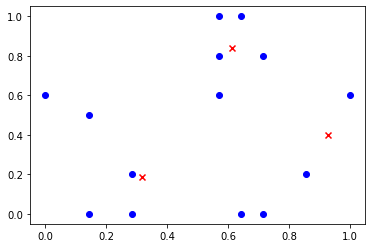

In [112]:
plt.scatter(data_norm[:,0],data_norm[:,1],color='b')
plt.scatter(les_centres[:,0],les_centres[:,1],color='r',marker='x')

<font size="+1" color="RED">**[Q]**</font> Ecrire la fonction <code>affiche_resultat()</code> qui permet d'afficher le résultat de l'algorithme en utilisant des couleurs différentes pour les clusters trouvés (pour faire simple, on peut ne considèrer que le cas où K vaut 3).

*Remarque*: La librairie matplotlib permet de manipuler aisément des couleurs:
http://matplotlib.org/api/cm_api.html

In [113]:
def affiche_resultat(data, centroides, dictAffect):
    clusters = dictAffect.keys()
    for i in clusters:
        plt.scatter(centroides[i][0],centroides[i][1],color='r',marker='x')
        plt.scatter(data[dictAffect[i],0],data[dictAffect[i],1],marker='o')

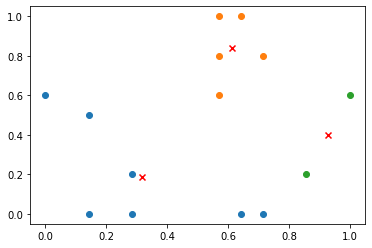

In [114]:
affiche_resultat(data_norm,les_centres,l_affectation)

### Expérimentations

<font size="+1" color="RED">**[Q]**</font> Expérimenter l'algorithme des k-moyennes sur les données. Etudier l'impact du choix de $K$ sur l'inertie globale finale. Faire de même en relançant plusieurs fois l'algorithme avec la même valeur de $K$, en modifiant la valeur de epsilon ou de max_iter, etc.

## Questions de cours (à faire sur feuille)

Pour vous entraîner sans machine...

<font size="+1" color="RED">**[Q]**</font> On considère un ensemble fini $U$ d'éléments. 
- donner la fonction caractéristique de $U$
- donner la fonction caractéristique de l'ensemble vide
- soit $E$ et $F$ deux sous-ensembles de $U$ définis par leurs fonctions caractéristiques $\chi_E$ et $\chi_F$. En déduire les fonctions caractéristiques de $E\cup F$, de $E\cap F$ et de $E^{c}$. *(indice: penser au min et au max)*

<font size="+1" color="RED">**[Q]**</font> Rappeler la définition d'une partition $P$ d'un ensemble $X$ en $K$ sous-ensembles. 

<font size="+1" color="RED">**[Q]**</font> Appliquer, à la main, l'algorithme des K-moyennes sur les données fournies sur le transparent 8 du cours 9 en utilisant d'abord $K=2$, puis $K=3$. Dans chacun des cas, réaliser au maximum 10 itérations de l'algorithme ($t_{max}=10$).
Comparer les résultats obtenus.


---